In [102]:
import numpy as np
from scipy.optimize import check_grad
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd

## Generating data

In [103]:
def generate_data(n=10, d=1000, lam=10):
    X = np.random.rand(n,d)
    w = np.random.rand(d)
    w[np.random.permutation(d)[:d*90//100]] = 0
    y = X.dot(w)
    #y = np.random.rand(n)
    Q = np.eye(n)*0.5
    A = np.vstack([X.T,-X.T])
    b = np.ones(2*d)*lam
    p = y
    v0 = np.zeros(n)
    return X, y, Q, A, b, p, w, v0


In [104]:
X, y, Q, A, b, p, w, v0=generate_data()
lam=10

$$ \text{function}(v, t, Q, A, b, p) = t*(v^TQv + v^Tp) -\sum_{i=1}^{m} -log(b_i -A_iv) $$

In [105]:
def function(v, t, Q, A, b, p):
    """
    Objective function for the barrier method
    """
    v = v.reshape(-1,1)
    p = p.reshape(-1,1)
    b = b.reshape(-1,1)

    return t*(v.T.dot(Q).dot(v) + v.T.dot(p))[0][0] -np.log((b-A.dot(v))).sum()

$$ \text{general_function}(v, Q, p) = v^TQv + v^Tp $$

In [106]:
def general_function(v, Q, p):
    """
    Global objective function we want to maximize subject to the constraints
    """
    v = v.reshape(-1,1)
    p = p.reshape(-1,1)
    return (v.T.dot(Q).dot(v) + v.T.dot(p))[0][0] 

In [107]:
def check_feasibility(v,A,b):
    """
    Checking the constraint for the backtracking linesearch
    """
    return (A.dot(v)<=b).all()

$$ \nabla(v, t, Q, A, b, p) = t*(2Qv + p) + A^Td $$ 

where $$d_i = 1/(b_i -A_iv)$$

In [108]:
def gradient(v, t, Q, A, b, p):
    """
    Gradient of the objective function
    """
    v = v.reshape(-1,1)
    p = p.reshape(-1,1)
    b = b.reshape(-1,1)
    d = 1/(b-A.dot(v))
    grad  =  t*(2*Q.dot(v)+p) +  A.T.dot(d)
    return grad.reshape(-1)

$$ \nabla^2(v, t, Q, A, b) = t*(2Q) + A^T\text{diag}(d)A $$ 

where $$d_i = 1/(b_i -A_iv)$$

In [109]:
def hessian(v, t, Q, A, b):
    """
    Hessian of the objective function
    """
    v = v.reshape(-1,1)
    b = b.reshape(-1,1)
    d = 1/(b-A.dot(v))
    hess = A.T.dot(np.power(np.diag(d.reshape(-1)),2)).dot(A) + 2*t*Q
    return hess

In [110]:
t=1

In [111]:
# numerically checking the gradient on 0
check_grad(func=lambda x:function(x, t, Q, A, b, p),
           grad=lambda x:gradient(x, t, Q, A, b, p),
           x0=v0)

0.00022000993506701835

In [112]:
def centering_step(Q, p, A, b, t, v0 ,eps):
    """
    Centering step method implmenting the Newton method for the barrier function.
    """
    v_sequence = []
    v_sequence.append(v0)
    v = deepcopy(v0)
    lambda_2_sequence = []
    convergence = False
    while(not(convergence)):
        inv_hess = np.linalg.inv(hessian(v, t, Q, A, b))
        grad = gradient(v, t, Q, A, b, p)
        delta_x = -inv_hess.dot(grad)
        lambda_2 = grad.T.dot(inv_hess).dot(grad)
        lambda_2_sequence.append(lambda_2/2)
        if lambda_2/2 <= eps:
            convergence=True
            break
        else:
            v = v + delta_x*backtracking_linesearch(grad, delta_x, v, t, Q, A, b, p)
            v_sequence.append(deepcopy(v))
    return v_sequence, lambda_2_sequence

In [113]:
def backtracking_linesearch(grad, delta_x, v, t, Q, A, b, p):
    """
    Implementing the backtracking linesearch.
    """
    alpha=0.25
    beta=0.5
    t_backtrack = 1.0
    
    while(not(check_feasibility(v+t_backtrack*delta_x,A,b))
          or (function(v+t_backtrack*delta_x, t, Q, A, b, p)>function(v, t, Q, A, b, p)+alpha*t_backtrack*grad.T.dot(delta_x))):
        t_backtrack = beta*t_backtrack
    return t_backtrack

In [114]:
ts = [1,10,100,1000,10000]
eps = 10e-10

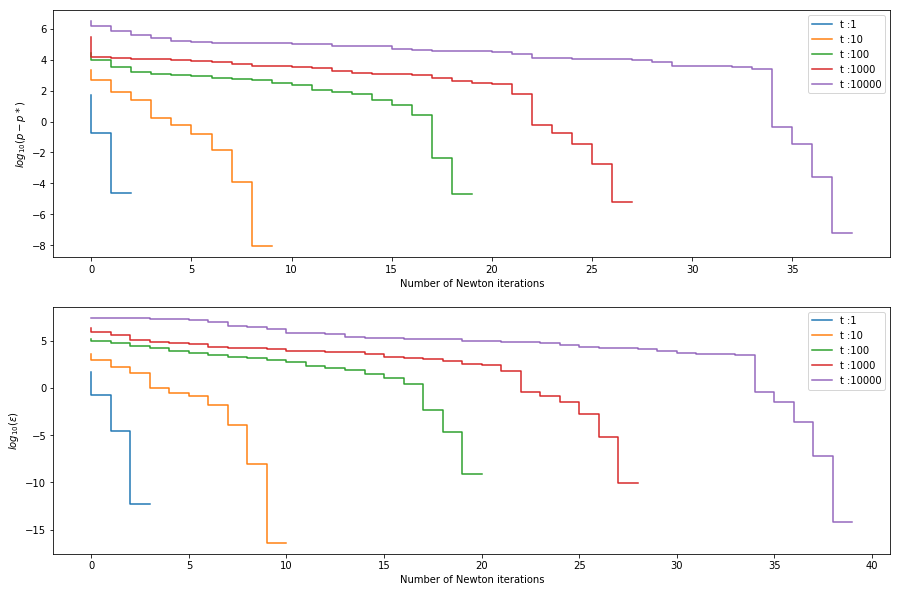

In [115]:
plt.figure(figsize=(15,10))
plt.title('Centering step for different values of t')
ax_1 = plt.subplot(2,1,1)
plt.xlabel('Number of Newton iterations')
plt.ylabel('$log_{10}(p-p*)$')

ax_2 = plt.subplot(2,1,2)
plt.xlabel('Number of Newton iterations')
plt.ylabel('$log_{10}(\epsilon)$')

for t in ts:
    v_sequence, lambda_2_sequence = centering_step(Q, p, A, b, t, v0 ,eps)
    function_values = []
    for v in v_sequence:
        function_values.append(function(v, t, Q, A, b, p))
    function_values = np.array(function_values)
    function_values = np.log10(function_values[:-1] - function_values[-1] )
    lambda_2_sequence = np.array(lambda_2_sequence)
    lambda_2_sequence = np.log10(lambda_2_sequence)

    ax_1.step(range(len(v_sequence)-1),function_values, label='t :'+ str(t))
    ax_1.legend()
    
    ax_2.step(range(len(lambda_2_sequence)),lambda_2_sequence, label='t :'+ str(t))
    ax_2.legend()

In [116]:
def barrier_method(Q, p, A, b, v0, eps, t0, mu):
    """
    Implementing the barrier method
    """
    m = float(A.shape[0])
    t = t0
    v_sequence = []
    v_sequence.append(v0)
    v = deepcopy(v0)
    newton_iters = 0
    newton_iters_tab = []
    convergence=False
    while(not(convergence)):
        v_star = deepcopy(centering_step(Q, p, A, b, t, v ,eps)[0][-1])
        newton_iters += len(centering_step(Q, p, A, b, t, v ,eps)[0]) - 1
        newton_iters_tab.append(newton_iters)
        v = v_star
        v_sequence.append(v_star)
        if m/t < eps:
            convergence = True
            break
        else:
            t = mu*t
    return v_sequence,newton_iters_tab, t


2
5
10
15
20
50
100
500


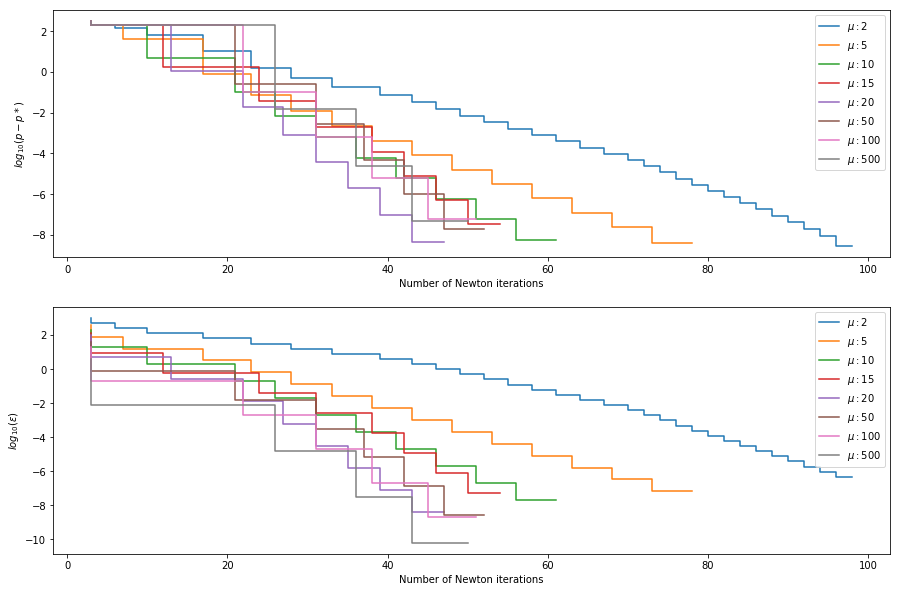

In [127]:
plt.figure(figsize=(15,10))
plt.title('Barrier method for different values of '+'$\mu$')
ax_1 = plt.subplot(2,1,1)
plt.xlabel('Number of Newton iterations')
plt.ylabel('$log_{10}(p-p*)$')

ax_2 = plt.subplot(2,1,2)
plt.xlabel('Number of Newton iterations')
plt.ylabel('$log_{10}(\epsilon)$')

mus = [2, 5, 10, 15, 20, 50, 100, 500]

eps = 10e-7
for mu in mus:
    print(mu)
    t0=1
    v_sequence, newton_iters_tab, t=barrier_method(Q,p,A,b,v0,eps=eps,t0=t0,mu=mu)
    eps_sequence = np.log10(np.array([float(A.shape[0])/(t0*mu**(i+1)) for  i in range(len(v_sequence) -1)]))
    function_values = []
    for v in v_sequence:
        function_values.append(general_function(v, Q, p))
    function_values = np.array(function_values)
    function_values = np.log10(function_values[:-1] - function_values[-1])  
    ax_1.step(newton_iters_tab,function_values,label='$\mu:$' +str(mu))
    ax_1.legend()    
    
    ax_2.step(newton_iters_tab,eps_sequence,label='$\mu:$' +str(mu))
    ax_2.legend()


In [119]:
v_sequence, newton_iters_tab, t =barrier_method(Q,p,A,b,v0,eps=10e-6,t0=1,mu=50)

In [120]:
def get_primal_from_dual(v, A, b , t, d=1000):
    """
    Get primal solution from the dual
    """
    v = v.reshape(-1)
    res = -1/(t*(A.dot(v)-b))
    res = -res[:d]+ res[d:]
    return res

In [121]:
w_prime = get_primal_from_dual(v_sequence[-1], A, b , t)

$$ \text{objective primal} = \frac{1}{2}||X\omega -y||^2_2  +\lambda||\omega||_1$$

In [128]:
def objective_primal(X,w,y,lam):
    """
    Objective function of the dual
    """
    y = y.reshape(-1,1)
    w = w.reshape(-1,1)
    f = 0.5*(X.dot(w)-y).T.dot(X.dot(w)-y) + lam*np.linalg.norm(w.reshape(-1), ord=1)
    return f[0][0]

In [123]:
objective_primal(X,w_prime,y,lam)

297.5556909849526

In [124]:
-general_function(v_sequence[-1], Q, p)

297.55567420713857

Text(0.5, 1.0, 'Coefficients of the primal solution')

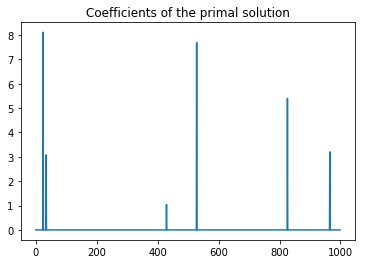

In [131]:
plt.plot(w_prime)
plt.title('Coefficients of the primal solution')

#### Influence of $\mu$ on the primal solution

2
5
10
15
20
50
100
500


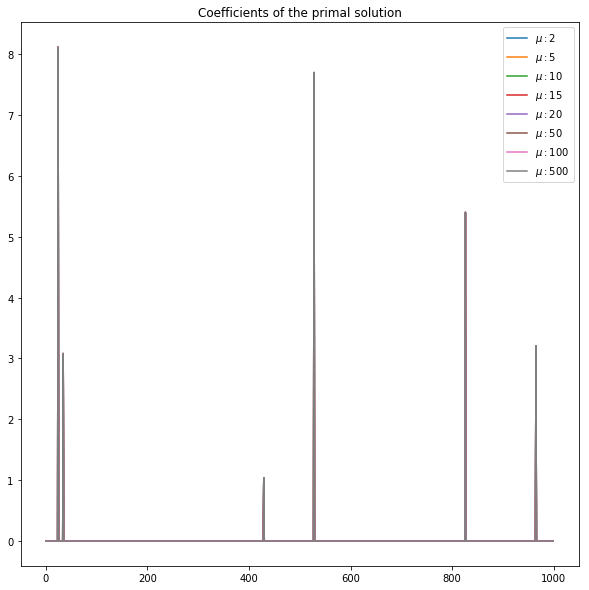

In [134]:
plt.figure(figsize=(10,10))
plt.title('Coefficients of the primal solution')
for mu in mus:
    print(mu)
    v_sequence, newton_iters_tab, t =barrier_method(Q,p,A,b,v0,eps=10e-6,t0=1,mu=mu)
    w_prime = get_primal_from_dual(v_sequence[-1], A, b , t)
    plt.plot(w_prime,label='$\mu:$' +str(mu))
    plt.legend()
 